In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('../data/Life Expectancy Data.csv')
pd.set_option('display.max_columns', 50)

In [3]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [5]:
# fix spacing in column names
df.columns = df.columns.str.strip().str.replace(" ","_").str.lower()
df.rename(columns={"thinness__1-19_years": "thinness__10-19_years"}, inplace=True)

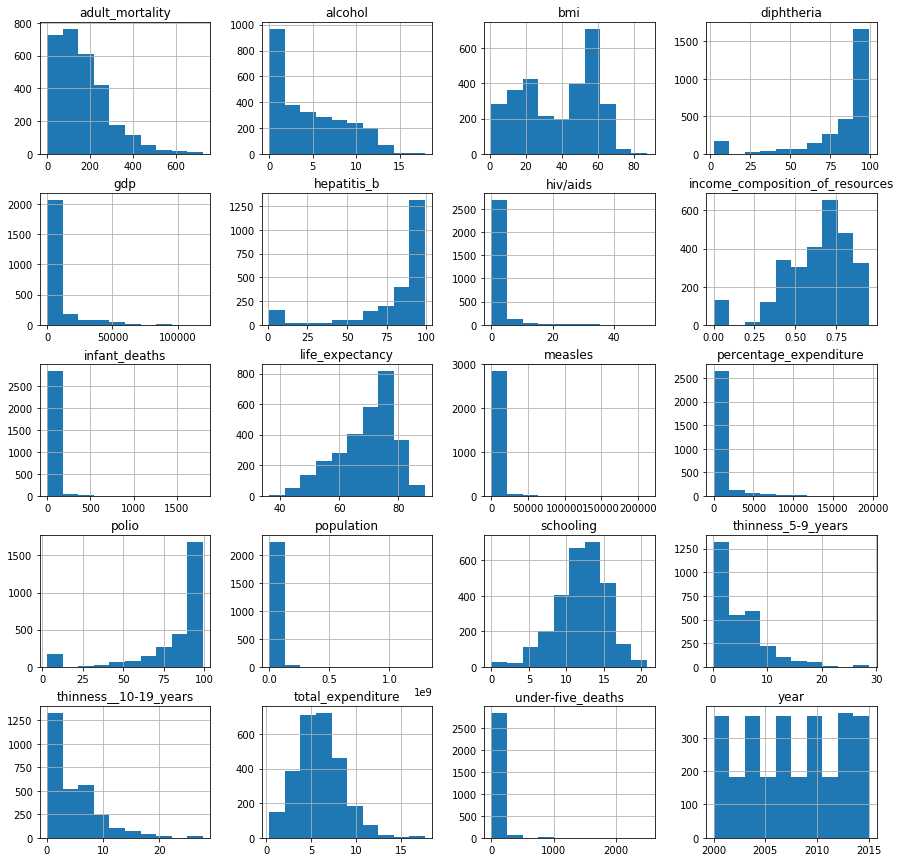

In [6]:
df.hist(figsize=(15,15))
plt.show()

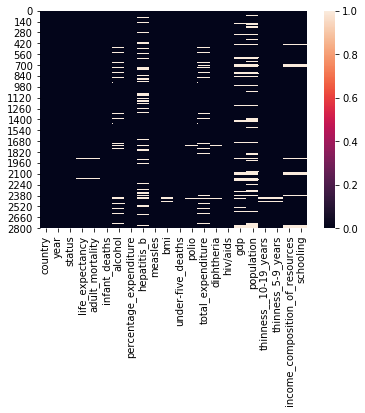

In [7]:
# checking missing values
sns.heatmap(pd.isnull(df))

In [8]:
df.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy                     10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles                              0
bmi                                 34
under-five_deaths                    0
polio                               19
total_expenditure                  226
diphtheria                          19
hiv/aids                             0
gdp                                448
population                         652
thinness__10-19_years               34
thinness_5-9_years                  34
income_composition_of_resources    167
schooling                          163
dtype: int64

In [9]:
# dropping nans from life expectancy
df.drop(df[df['life_expectancy'].isna()].index, inplace=True)

In [10]:
# adult mortality is skewed to the right, nans will be replaced with the median value
df['adult_mortality']=df['adult_mortality'].fillna(value=df['adult_mortality'].median())

In [11]:
# creating a new median value of alcohol consumption from the median of each country

country = df.groupby('country').median()['alcohol'].index
alc_score = df.groupby('country').median()['alcohol']
country_alc = list(zip(country, alc_score))
country_alc_dict = dict()

for item in country_alc:
    country_alc_dict[item[0]] = item[1]
    

In [12]:
missing_alc_index = df[df.alcohol.isna()].country.map(country_alc_dict).index
missing_alc_values = df[df.alcohol.isna()].country.map(country_alc_dict)
df.loc[missing_alc_index, 'alcohol'] = missing_alc_values

In [13]:
# nans for missing hepatitis are skewed similarly to alcohol consumption, so will be treated the same way

country = df.groupby('country').median()['hepatitis_b'].index
hep_score = df.groupby('country').median()['hepatitis_b']
country_hep = list(zip(country, hep_score))
country_hep_dict = dict()

for item in country_hep:
    country_hep_dict[item[0]] = item[1]


In [14]:
missing_hep_index = df[df.hepatitis_b.isna()].country.map(country_hep_dict).index
missing_hep_values = df[df.hepatitis_b.isna()].country.map(country_hep_dict)
df.loc[missing_hep_index, 'hepatitis_b'] = missing_hep_values

In [15]:
df.hepatitis_b.isna().sum()

144

In [16]:
df[df.hepatitis_b.isna()].status.value_counts()

Developed     128
Developing     16
Name: status, dtype: int64

In [17]:
# replacing the remaining nans with the median of developing vs developed countries

developed = df.groupby('status').median()['hepatitis_b'][0]
developing = df.groupby('status').median()['hepatitis_b'][1]
developed, developing

(95.0, 89.0)

In [18]:
df.loc[df[(df.hepatitis_b.isna()) & (df.status == 'Developed')].index, 'hepatitis_b'] = developed
df.loc[df[(df.hepatitis_b.isna()) & (df.status == 'Developing')].index, 'hepatitis_b'] = developing

In [19]:
df.hepatitis_b.isna().sum()

0

In [20]:
# again, BMI nans will get the same treatment as previous columns

country = df.groupby('country').median()['bmi'].index
bmi_score = df.groupby('country').median()['bmi']
country_bmi = list(zip(country, bmi_score))
country_bmi_dict = dict()

for item in country_bmi:
    country_bmi_dict[item[0]] = item[1]

In [21]:
missing_bmi_index = df[df.bmi.isna()].country.map(country_bmi_dict).index
missing_bmi_values = df[df.bmi.isna()].country.map(country_bmi_dict)
df.loc[missing_bmi_index, 'bmi'] = missing_bmi_values

In [23]:
df.bmi.isna().sum()

32

In [24]:
df[df.bmi.isna()].status.value_counts()

Developing    32
Name: status, dtype: int64

In [25]:
# replacing the remaining nans with the median of developing vs developed countries

developed = df.groupby('status').median()['bmi'][0]
developing = df.groupby('status').median()['bmi'][1]
developed, developing

(57.45, 35.150000000000006)

In [26]:
df.loc[df[(df.bmi.isna()) & (df.status == 'Developed')].index, 'bmi'] = developed
df.loc[df[(df.bmi.isna()) & (df.status == 'Developing')].index, 'bmi'] = developing

In [27]:
df.bmi.isna().sum()

0

In [28]:
# same for nans in polio

country = df.groupby('country').median()['polio'].index
pol_score = df.groupby('country').median()['polio']
country_pol = list(zip(country, pol_score))
country_pol_dict = dict()

for item in country_pol:
    country_pol_dict[item[0]] = item[1]

In [29]:
missing_pol_index = df[df.polio.isna()].country.map(country_pol_dict).index
missing_pol_values = df[df.polio.isna()].country.map(country_pol_dict)
df.loc[missing_pol_index, 'polio'] = missing_pol_values

In [30]:
df.polio.isna().sum()

0

In [31]:
# filling nans in missing expenditure

country = df.groupby('country').median()['total_expenditure'].index
exp_score = df.groupby('country').median()['total_expenditure']
country_exp = list(zip(country, exp_score))
country_exp_dict = dict()

for item in country_exp:
    country_exp_dict[item[0]] = item[1]

In [32]:
missing_exp_index = df[df.total_expenditure.isna()].country.map(country_exp_dict).index
missing_exp_values = df[df.total_expenditure.isna()].country.map(country_exp_dict)
df.loc[missing_exp_index, 'total_expenditure'] = missing_exp_values

In [33]:
df.total_expenditure.isna().sum()

32

In [34]:
df[df.total_expenditure.isna()].status.value_counts()

Developing    32
Name: status, dtype: int64

In [35]:
# filling remaining nans with the same missing BMI procedure
developed = df.groupby('status').median()['total_expenditure'][0]
developing = df.groupby('status').median()['total_expenditure'][1]
developed, developing

(7.895, 5.39)

In [36]:
df.loc[df[(df.total_expenditure.isna()) & (df.status == 'Developed')].index, 'total_expenditure'] = developed
df.loc[df[(df.total_expenditure.isna()) & (df.status == 'Developing')].index, 'total_expenditure'] = developing

In [37]:
df.total_expenditure.isna().sum()

0